In [2]:
#imports
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import json
from tqdm import tqdm
import yaml

#import geopandas as gpd
import pandas as pd

import torch

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt
import utils.processing as proc
import utils.eval_pipe as eval

import utils.model_loader as md
import utils.data_loader as dt
import utils.config_loader as cf

%load_ext autoreload
%autoreload 2


In [20]:
run_ids = ["251102_ALLIN_" + str(i) for i in range(5)]
# SELECT EXPERIMENTAL CONFIG
for run_id in tqdm(run_ids):
    with open('../configs/experiments.yaml', 'r') as f:
        experiments = yaml.safe_load(f)
        # experiment_names = list(experiments.keys())
        #run_id = "251009_4" #"250929_02" #"250930_1"
        exp_dir = os.path.join("..", "results", run_id, "train")
        experiment_names = sorted(
            [name for name in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, name))]
        )
        #experiment_names = experiment_names[6:7]  # Select the first 7 experiment names
        print("Available experiments:", experiment_names)
        

100%|██████████| 5/5 [00:00<00:00, 31.32it/s]

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


# Experimental dimensions

In [12]:
def plot_experiment_matrix(experiments, order_exps=None, figsize=(14, 6), cmap="Greens"):
  """
  Visualize experiment configs as a binary/config matrix.
  Rows = experiments (index), Columns = features:
    - spectral seasons (prefixed 'season:')
    - spectral quantiles (prefixed 'quantile:')
    - aux inputs (prefixed 'aux:')
    - outputs (prefixed 'out:'; annotated with loss/weight when available)
    - strategy (prefixed 'strategy:')
  A colored cell indicates presence; annotation shows 'x' for simple presence
  or for outputs shows "<loss>|w=<weight>" if available.

  Args:
    experiments (dict): mapping experiment_name -> config dict
    order_exps (list, optional): list of experiment names to control row order
    figsize (tuple): matplotlib figure size
    cmap (str): colormap for seaborn.heatmap
  Returns:
    pd.DataFrame: binary presence matrix (0/1)
  """
  # collect experiment names
  exp_names = list(experiments.keys()) if order_exps is None else order_exps
  # gather all possible columns
  seasons = set()
  quantiles = set()
  aux_inputs = set()
  outputs = set()
  strategies = set()

  for name in exp_names:
    cfg = experiments.get(name, {})
    spec = cfg.get("spectral", {}) or {}
    s = spec.get("seasons", []) or []
    q = spec.get("quantiles", []) or []
    for si in s: seasons.add(si)
    for qi in q: quantiles.add(qi)
    for ai in (cfg.get("aux_inputs") or []): aux_inputs.add(ai)
    for out_name in (cfg.get("outputs") or {}).keys(): outputs.add(out_name)
    strategies.add(cfg.get("strategy", "None"))

  # build ordered column list
  col_list = []
  # strategy columns (one-hot)
  strat_cols = [f"strategy:{s}" for s in sorted(strategies)]
  col_list.extend(strat_cols)
  # spectral
  season_cols = [f"season:{s}" for s in sorted(seasons)]
  quantile_cols = [f"quantile:{q}" for q in sorted(quantiles)]
  col_list.extend(season_cols)
  col_list.extend(quantile_cols)
  # aux inputs
  aux_cols = [f"aux:{a}" for a in sorted(aux_inputs)]
  col_list.extend(aux_cols)
  # outputs
  out_cols = [f"out:{o}" for o in sorted(outputs)]
  col_list.extend(out_cols)

  # prepare matrices
  mat = pd.DataFrame(0, index=exp_names, columns=col_list, dtype=int)
  annot = pd.DataFrame("", index=exp_names, columns=col_list)

  for name in exp_names:
    cfg = experiments.get(name, {}) or {}
    # strategy
    strat = cfg.get("strategy", None)
    if strat is not None:
      col = f"strategy:{strat}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "✔"
    # spectral
    spec = cfg.get("spectral", {}) or {}
    for s in spec.get("seasons", []) or []:
      col = f"season:{s}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "✔"
    for q in spec.get("quantiles", []) or []:
      col = f"quantile:{q}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "✔"
    # aux inputs
    for a in cfg.get("aux_inputs", []) or []:
      col = f"aux:{a}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "✔"
    # outputs: annotate with loss and weight if present
    for out_name, out_cfg in (cfg.get("outputs") or {}).items():
      col = f"out:{out_name}"
      if col in mat.columns:
        mat.at[name, col] = 1
        loss = out_cfg.get("loss")
        weight = out_cfg.get("weight")
        if loss is None and weight is None:
          annot.at[name, col] = "x"
        else:
          pieces = []
          if loss is not None:
            if loss == "crossentropy":
              loss = "ce"
            pieces.append(str(loss))
          # if weight is not None:
          #   pieces.append(f"w={weight}")
          annot.at[name, col] = "|".join(pieces)

  # Plot with seaborn heatmap and string annotations
  import seaborn as sns  # seaborn is available in notebook; import again is harmless
  fig = plt.figure(figsize=figsize)
  ax = sns.heatmap(mat, cmap=cmap, cbar=False, linewidths=0.5, linecolor="#dddddd",
       annot=annot.values, fmt="", annot_kws={"fontsize": 14}, vmin=0, vmax=3)
  ax.set_ylabel("")  # experiments are rows already
  ax.set_xlabel("")  # columns explain themselves
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=14)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=14)

  # Add bold vertical lines
  strategy_end = len(strat_cols)
  inputs_end = strategy_end + len(season_cols) + len(quantile_cols) + len(aux_cols)
  ax.axvline(x=strategy_end, color="black", linewidth=2)  # Line after strategy
  ax.axvline(x=inputs_end, color="black", linewidth=2)    # Line after all inputs
  ax.axhline(y=1, color="black", linewidth=2) 
  ax.axhline(y=4, color="black", linewidth=2) 
  ax.axhline(y=6, color="black", linewidth=2) 



  plt.title("Model Configuration Sequence - Experiment Matrix", fontsize=16)
  plt.tight_layout()
  plt.show()

  return fig, mat

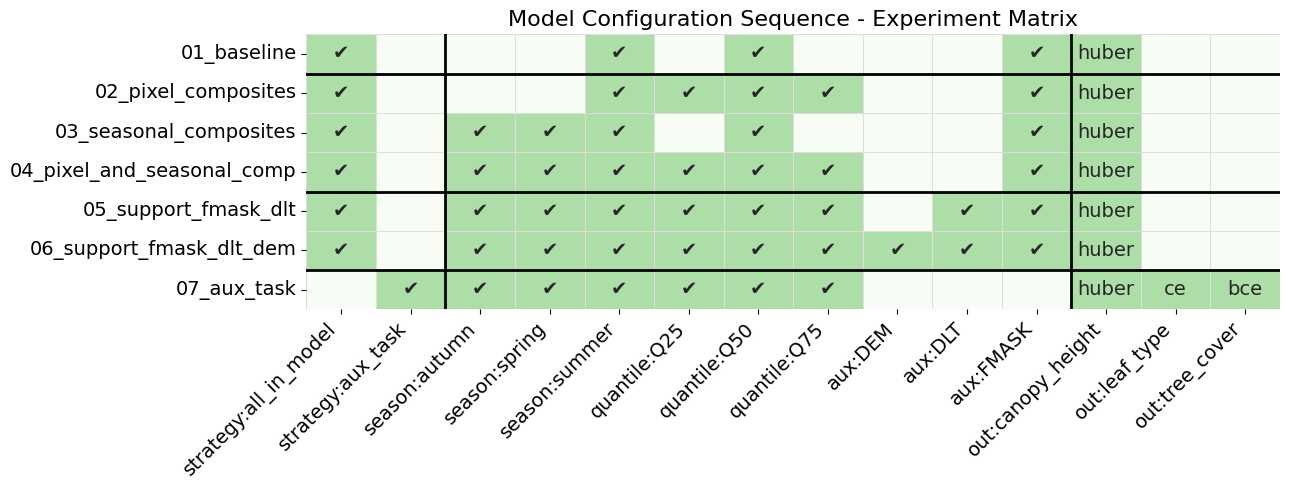

In [13]:
exp_tmp = {k: experiments[k] for k in list(experiments.keys())[1:8]}
fig, mat = plot_experiment_matrix(exp_tmp, figsize=(13, 5), cmap="Greens")
path = "../graphics/05_ExperimentalConfig.pdf"
fig.savefig(path)


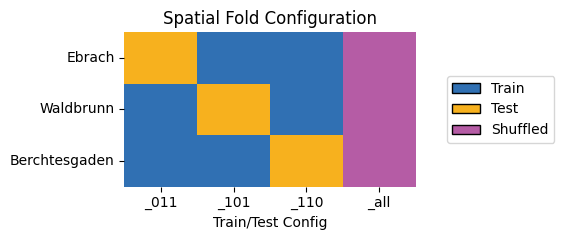

In [15]:
combodict = {
        "_011": "Ebrach",
        "_101": "Waldbrunn",
        "_110": "Berchtesgaden",
        "_all": "All Sites"
    }

# do a little matrix visualization, rows = Sitenames, taken from combodict, columns is the key of combodict, titled Train/Test Config. the Dataset with 0 is test set, 1 is train. illustrate the generalization setup.
import seaborn as sns
import matplotlib.pyplot as plt
data = []
for combo, sitename in combodict.items():
    row = []
    for key in combodict.keys():
        if combo == key:
            row.append(5.0)
        else:
            row.append(1.0)
    data.append(row)

#append one extra row for "_all" with all 1s
#data.append([1.0]*len(combodict))
#combodict["_all"] = "All Sites"
# do a little matrix visualization, rows = Sitenames, taken from combodict, columns is the key of combodict, titled Train/Test Config. 
# The Dataset with 0 is test set, 1 is train. Illustrate the generalization setup.

#set the col _all to 0.7 for all rows 
for i in range(len(data)):
    data[i][3]= 3

data = data[:3]
# Create a heatmap
fig = plt.figure(figsize=(7, 2.5))
# Custom color palette
palette = [0x072140, 0x3070B3, 0x8F81EA, 0xB55CA5, 0xFED702, 0xF7B11E, 0x9FBA36]
palette = [f'#{color:06X}' for color in palette]
ax = sns.heatmap(data, annot=False, fmt="f", cmap=palette, vmin=0, vmax=6,cbar=False, xticklabels=list(combodict.keys())[:4], yticklabels=list(combodict.values())[:3])

# Add labels and title
ax.set_xlabel("Train/Test Config")
ax.set_ylabel("")
ax.set_title("Spatial Fold Configuration")

# Add a legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=palette[1], edgecolor='black', label='Train'),
                    Patch(facecolor=palette[5], edgecolor='black', label='Test'),
                   Patch(facecolor=palette[3], edgecolor='black', label='Shuffled')]
plt.legend(handles=legend_elements, loc='center right', title="",bbox_to_anchor=(1.5, 0.5))
plt.grid(False)
plt.tight_layout()
#plt.show()
path = "../graphics/05_SpatialConfig.pdf"
fig.savefig(path)

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


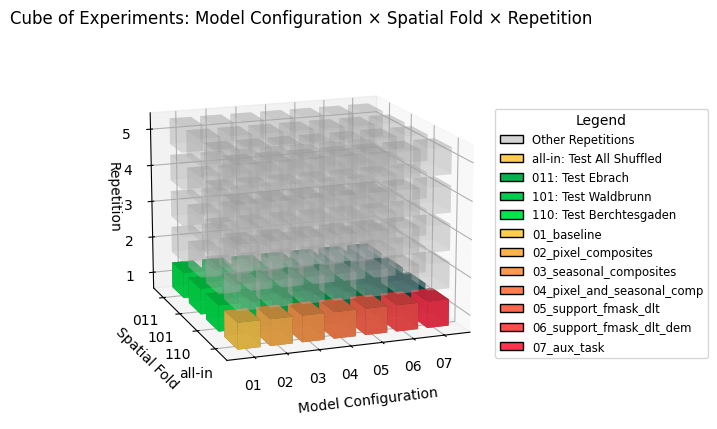

In [16]:
import numpy as np
import matplotlib.pyplot as plt

x_labels = [f"0{i+1}" for i in range(7)]
y_labels = ["all-in","110", "101", "011"]
z_labels = [f"{i+1}" for i in range(5)]

with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[1:8]  # Select the first 7 experiment names
    print("Available experiments:", experiment_names)
    # Create a mapping from experiment names to their display names

combodict = {
        "all-in": "All Shuffled",
        "011": "Ebrach",
        "101": "Waldbrunn",
        "110": "Berchtesgaden"
    }

fig = plt.figure(figsize=(5, 6))
ax = fig.add_subplot(111, projection='3d')

_x = np.arange(len(x_labels))
_y = np.arange(len(y_labels))
_z = np.arange(len(z_labels))

dx = dy = dz = 0.7  # box size

for xi in _x:
    for yi in _y:
        for zi in _z:
            if zi == 0:  # Only Rep1
                if yi == 0:  # all-in fold
                    color = (1.0, 0.8 - 0.1*xi, 0.3)
                else:
                    color = (0.0, 0.9 - 0.1*xi, 0.3)
                ax.bar3d(xi, yi, zi, dx, dy, dz, color=color, alpha=0.9, shade=True)
            else:
                ax.bar3d(xi, yi, zi, dx, dy, dz, color='whitesmoke', alpha=0.25, shade=True)

ax.set_xticks(_x + dx/2)
ax.set_xticklabels(x_labels, rotation=0, ha='right')
ax.set_yticks(_y + dy/2)
ax.set_yticklabels(y_labels)
ax.set_zticks(_z + dz/2)
ax.set_zticklabels(z_labels)
ax.set_xlabel("\nModel Configuration")
ax.set_ylabel("Spatial Fold")
ax.set_zlabel("Repetition", labelpad=-2, ha='left', rotation=180)
ax.set_title("Cube of Experiments: Model Configuration × Spatial Fold × Repetition")
ax.view_init(azim=-110, elev=15)

# add a legend to the right, outside the plot
from matplotlib.patches import Patch

palette_combo = [(1.0, 0.8 - 0.1*i, 0.3) for i in range(len(x_labels))]

# Legend for spatial folds (y axis)
fold_colors = {
    "all-in": (1.0, 0.8, 0.3),
    "110": (0.0, 0.9, 0.3),
    "101": (0.0, 0.8, 0.3),
    "011": (0.0, 0.7, 0.3)
}
fold_patches = [
    Patch(facecolor=fold_colors[k], edgecolor='black', label=f"{k}: Test {v}") for k, v in combodict.items()
]

# Legend for experiment names (x axis)
exp_patches = [
    Patch(facecolor=palette_combo[i], edgecolor='black', label=f"{name}") for i, name in enumerate(experiment_names)
]

# Legend for repetitions (bars)
legend_elements = [
   # Patch(facecolor='olive', edgecolor='black', label='First Repetition'),
    Patch(facecolor='lightgrey', edgecolor='black', label='Other Repetitions')
]

# Place legends outside the plot
ax.legend(handles=legend_elements + fold_patches + exp_patches, 
          loc='upper left', bbox_to_anchor=(1.0, 0.8), borderaxespad=0., 
          title="Legend", fontsize='small')

#plt.tight_layout()
plt.grid(False)
plt.show()

path = "../graphics/experiment_cube.pdf"
fig.savefig(path, bbox_inches='tight')


## a pseudo loss surface

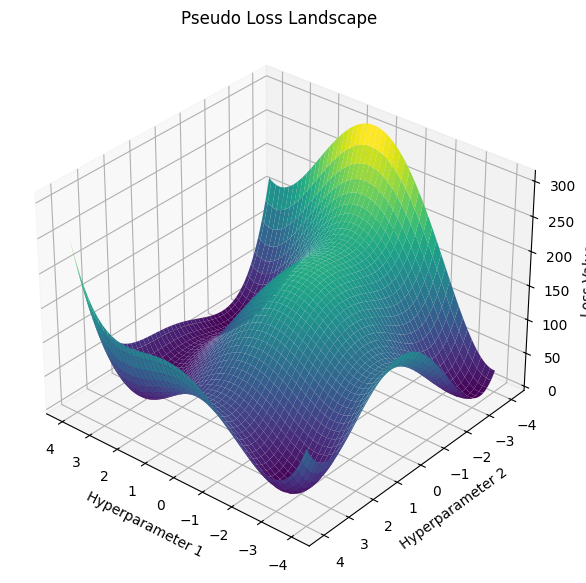

In [18]:
# generate a nice 3D plot of any complex surface, e.g., loss landscape over two hyperparameters
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
# Create a grid of hyperparameter values
min, max = -4,4
hp1 = np.linspace(min, max, 100)
hp2 = np.linspace(min, max, 100)
hp1, hp2 = np.meshgrid(hp1, hp2)    
# Define a complex surface function (e.g., loss landscape)
def complex_surface(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2
# Compute the surface values
z = complex_surface(hp1, hp2)
# Plot the 3D surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(hp1, hp2, z, cmap='viridis', edgecolor='none')
ax.set_title('Pseudo Loss Landscape')
ax.set_xlabel('Hyperparameter 1')
ax.set_ylabel('Hyperparameter 2')
ax.set_zlabel('Loss Value')
ax.view_init(elev=32, azim=130)  # Adjust view angle for better visualization
plt.show()